# Classify tweets into AV/not AV
1. Combine probabilities for AV topics and non-AV topics, save them in 2 columns
2. Assign quantiles for each column
3. Uniform randomly select tweets from each quantile from each column, make additional columns for labeling
4. Save this csv to google drive
5. Logistic regression


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import os
import glob
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

In [ ]:
# set working directory
# cwd = "drive/MyDrive/Topic Modeling/" # Ximin
cwd = "drive/Shareddrives/AV_Twitter_Project/Topic Modeling" # Ran

## Sample data for hand labeling

In [ ]:
# load data
data_path = os.path.join(cwd, "data/opinion_modeling/av_classification")
df = pd.read_csv(os.path.join(data_path, "doc_topic.csv"), lineterminator="\n")

# merge av cols
prob_cols = [col for col in df.columns if "prob" in col]
av_cols = [prob_cols[1], prob_cols[-2]]
nonav_cols = [col for col in prob_cols if col not in av_cols]
df = df.assign(AV=df[av_cols].sum(axis=1))
df = df.assign(Non_AV=df[nonav_cols].sum(axis=1))

# quantize av column
num_quantiles = 4
quantile_ranks = pd.qcut(
    df2["AV"], 
    num_quantiles, 
    labels=[i + 1 for i in range(num_quantiles)]
)
df = df.assign(quantile=quantile_ranks)

# group by quantile sample
seed = 0
sample_ratio = 1 / 30
df_sample = df.groupby("quantile").apply(
    pd.DataFrame.sample, frac=sample_ratio, random_state=seed
).reset_index(drop=True)
print(f"sample data size: {df_sample.shape}")

# save sample data for hand labeling
# df_sample.to_csv(os.path.join(data_path, "sample1.csv"), index=False)

sample data size: (1000, 15)


## Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
# merge raw and sample datafame (forgot to seed sampling above)
data_path = os.path.join(cwd, "data/opinion_modeling/av_classification/")
df_raw = pd.read_csv(os.path.join(data_path, "doc_topic.csv"), lineterminator="\n")
df_labeled = pd.read_csv(os.path.join(data_path, "av_labeled.csv"))
df_labeled = df_labeled.dropna()

df = df_raw.join(df_labeled, lsuffix="text", rsuffix="text")
df = df.dropna()
print(f"combined data size: {df.shape}")

combined data size: (1000, 17)


### 1. Logistic regression with AV feature

In [ ]:
# train test split
seed = 0
test_ratio = 0.2

X = df["AV"].values.reshape(-1, 1)
y = df["class"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_ratio, random_state=seed
)

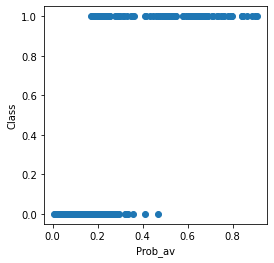

In [ ]:
# plot feature and class
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(X_train, y_train, "o")
ax.set_xlabel("Prob_av")
ax.set_ylabel("Class")
plt.show()

In [ ]:
# train-predict
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
pred = clf.predict_proba(X_test)

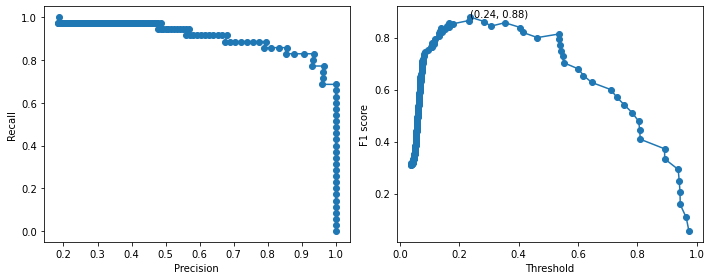

In [ ]:
# model selection
precision, recall, thresholds = metrics.precision_recall_curve(y_test, pred[:, 1])
F1 = 2 * (precision * recall) / (precision + recall)

# find max F1
idx_max = F1.argmax()

# plot selection metrics
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(precision, recall, "-o")
ax[0].set_xlabel("Precision")
ax[0].set_ylabel("Recall")

ax[1].plot(thresholds, F1[:-1], "-o")
ax[1].text(
    thresholds[idx_max], 
    F1[idx_max], 
    f"({thresholds[idx_max]:.2f}, {F1[idx_max]:.2f})"
)
ax[1].set_xlabel("Threshold")
ax[1].set_ylabel("F1 score")

plt.tight_layout()
plt.show()